**Data Loading**

In [1]:
import os
import cv2
import glob
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
def load_data(image_dir, label_dir):
    images = []
    labels = []
    for img_path in glob.glob(f"{image_dir}/*.jpg"):
        img = cv2.imread(img_path)
        label_path = img_path.replace(image_dir, label_dir).replace(".jpg", ".txt")
        with open(label_path, 'r') as f:
            annotations = []
            for line in f.readlines():
                class_id, x, y, w, h = map(float, line.strip().split())
                annotations.append((class_id, x, y, w, h))
            images.append(img)
            labels.append(annotations)
    return images, labels

In [3]:
image_dir = 'D:/04_Personal_Files/Python/Ship_Detection_Model/Ship_Segmentation/DATASET/train/images'
label_dir = 'D:/04_Personal_Files/Python/Ship_Detection_Model/Ship_Segmentation/DATASET/train/labels'
images, labels = load_data(image_dir, label_dir)

**Data Preprocessing**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
def preprocess_data(images, labels, target_size=(300, 300)):
    processed_images = []
    processed_labels = []
    for img, anns in zip(images, labels):
        img_resized = cv2.resize(img, target_size)
        processed_images.append(img_resized)
        
        h, w = img.shape[:2]
        ssd_labels = []
        for ann in anns:
            class_id, x, y, box_w, box_h = ann
            xmin = (x - box_w / 2) * w
            ymin = (y - box_h / 2) * h
            xmax = (x + box_w / 2) * w
            ymax = (y + box_h / 2) * h
            ssd_labels.append([class_id, xmin, ymin, xmax, ymax])
        
        processed_labels.append(ssd_labels)
    
    return np.array(processed_images), processed_labels

In [14]:
X, y = preprocess_data(images, labels)

**Split Data**

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

**Encode Labels for Model Compatibility**

In [39]:
from tensorflow.keras.utils import to_categorical

In [40]:
MAX_BBOXES = 10

In [41]:
def encode_labels(labels, max_bboxes=MAX_BBOXES, num_classes=3):
    encoded_labels = np.zeros((len(labels), max_bboxes, 4 + num_classes))  # 4 for bbox, num_classes for one-hot class

    for i, boxes in enumerate(labels):
        for j, box in enumerate(boxes):
            if j >= max_bboxes:
                break
            class_id, xmin, ymin, xmax, ymax = box
            encoded_labels[i, j, 0:4] = [xmin, ymin, xmax, ymax]
            encoded_labels[i, j, 4:] = to_categorical(int(class_id), num_classes=num_classes)
    
    return encoded_labels

In [42]:
y_train_encoded = encode_labels(y_train)
y_val_encoded = encode_labels(y_val)

**Train Model (Define SSD Architecture)**

In [43]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Reshape, Concatenate

In [44]:
input_shape = (300, 300, 3)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
num_classes = 3 
output_units = 4 + num_classes

C:\Users\Tharuka.Wijenanda\AppData\Local\Temp\ipykernel_13040\2754093752.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


In [45]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(MAX_BBOXES * output_units)(x)
x = Reshape((MAX_BBOXES, output_units))(x)

In [46]:
model = Model(inputs=base_model.input, outputs=x)

In [47]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

**Train the Model**

In [ ]:
batch_size = 32
epochs = 10

In [48]:
history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val_encoded))


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.1790 - loss: 8709.4307 - val_accuracy: 0.2150 - val_loss: 11089.0303
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.2539 - loss: 8406.8223 - val_accuracy: 0.3600 - val_loss: 11015.3389
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3075 - loss: 6789.1094 - val_accuracy: 0.3650 - val_loss: 10896.2715
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3357 - loss: 6275.8779 - val_accuracy: 0.3400 - val_loss: 10668.6846
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3995 - loss: 5774.9561 - val_accuracy: 0.3300 - val_loss: 10096.0771
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3502 - loss: 5072.5566 - val_accuracy: 0.2600 - val_loss: 8838.0938
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.2855 - loss: 5081.6626 - val_accuracy: 0.2800 - val_loss: 8451.8564
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.2479 - loss: 4438.4873 

**Check Accuracy and Draw Validation Plots**

In [49]:
import matplotlib.pyplot as plt

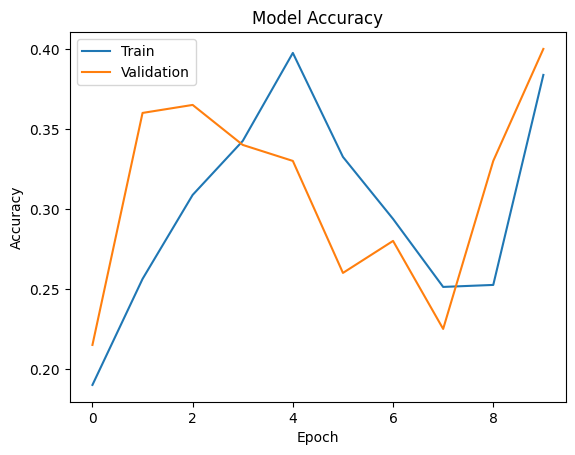

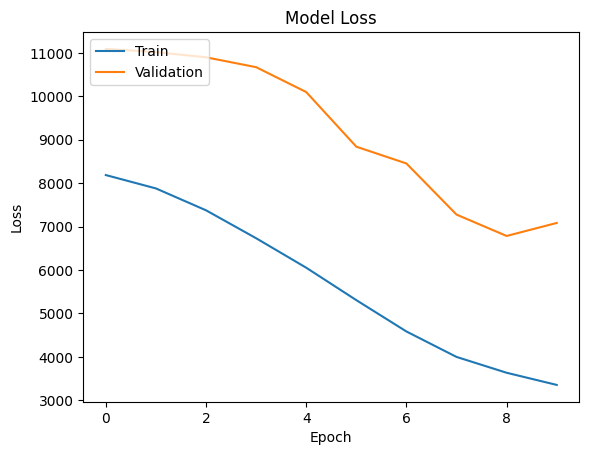

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Save the Model**

In [51]:
model.save('Models/ssd_model.keras')